<html>
<h3>Removing top layer of efficient net and loading our own classification layer</h3>

references:<br>
<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/">Tensorflow Documentation - Layers</a><br>
<a href="https://arxiv.org/pdf/1905.11946.pdf">Efficient Net and how it works</a><br>
<a href="https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/">Keras example for fine tuning</a><br>
<a href="https://www.tensorflow.org/guide/keras/train_and_evaluate">Tensorflow Documentation - Compiling and Evaluating</a><br>
<a href="https://keras.io/api/optimizers/">Keras Documentation - Optimisers</a><br>
<a href="https://keras.io/api/metrics/">Keras Documentation - Metrics</a><br>
<a href="https://keras.io/api/losses/">Keras Documentation - Losses</a><br>
<a href="https://keras.io/api/preprocessing/image/">Keras Documentation - Image Preprocess</a><br>
</html>

In [78]:
# importing required packages

from tensorflow.keras.applications import EfficientNetB0 as enet
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import ResizeMethod

import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import io
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
import pandas as pd

# for model plot
from tensorflow.keras.utils import plot_model

# for image sampling
import os
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

%matplotlib inline

In [79]:

# Setup constants and global parameters
train_folder = "../data/training"
validation_folder = "../data/validation"
eval_folder = "../data/evaluation"
save_folder = "../data/saved"
test_folder = "../data/test"

height = 224
width = 224
num_train = 800
num_valid = 200
batch_size = 16
v_batch_size = 8
t_batch_size = 4
epochs_to_run = 10
learning_rate = 2e-2
seed = 1    # to sample same augmented images
max_sample = 9    # max sampling must be perfect square  i.e. 9, 16, 25 etc.
fig_size = 8

In [80]:
# Display N x N grid of image set

def show_grid(x_generate, count, title):

    grid = round(math.sqrt(count))
    
    plt.figure(figsize=(fig_size,fig_size))
    for i in range(0,count):
        batch = x_generate.next()
        ax = plt.subplot(grid, grid, i + 1)
        image = batch[0][0].astype('uint8')
        if title:
            plt.title(batch[1][0].astype("int"))
        plt.tight_layout()
        plt.imshow(image)
    if title:
        print("Note: With Mask => [1 0],  Without Mask => [0 1]")
    # show the plot
    plt.show()

In [81]:
# to-do: fit the training set into the fine-tuned model to see if theres improvements
def plot_hist(hist, measure):
    v_measure = "val_" + measure

    plt.plot(hist.history[measure])
    plt.plot(hist.history[v_measure])
    plt.title("model " + measure)
    plt.ylabel(measure)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()



In [82]:
# loading pretrained model, setting input shape
inputs = (224, 224, 3)

# Selecting a topless model (sounds damn good...)
basemodel = enet(include_top=False, input_shape=inputs, weights="imagenet")

# locking the trained weights (freezing?)
basemodel.trainable = False 

# checking out how its like
basemodel.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization_4 (Normalization) (None, 224, 224, 3)  7           rescaling_4[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_4[0][0]            
_____________________________________________________________________________________

In [83]:
# plot_model(basemodel, to_file='model.png',show_shapes=True, show_layer_names=True)

In [84]:
# to rebuild top layer for our own classification

dropout_rate = 0.4 #i_dunno_yet - supposed to prevent overfit
types = 2 #currently only mask and no mask 

# building up the model in sequence
model = models.Sequential()

# loading the original topless model
model.add(basemodel)

# adding top layers 
model.add(layers.GlobalMaxPooling2D(name="gap"))

model.add(layers.Dropout(dropout_rate, name="drout"))

model.add(layers.Dense(types, activation="softmax", name="classdense"))

# view the assembled model
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
drout (Dropout)              (None, 1280)              0         
_________________________________________________________________
classdense (Dense)           (None, 2)                 2562      
Total params: 4,052,133
Trainable params: 2,562
Non-trainable params: 4,049,571
_________________________________________________________________


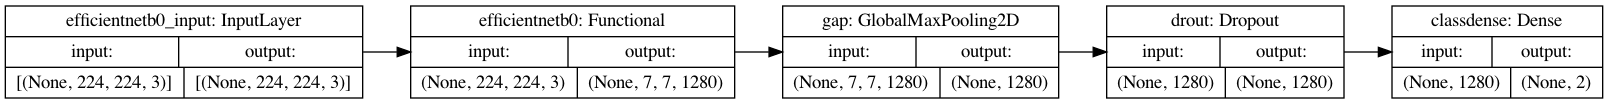

In [85]:
# Display model layers
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True, rankdir ="LR")

Found 1600 images belonging to 2 classes.
TRAINING SET: Sampling original training images ...
Note: With Mask => [1 0],  Without Mask => [0 1]


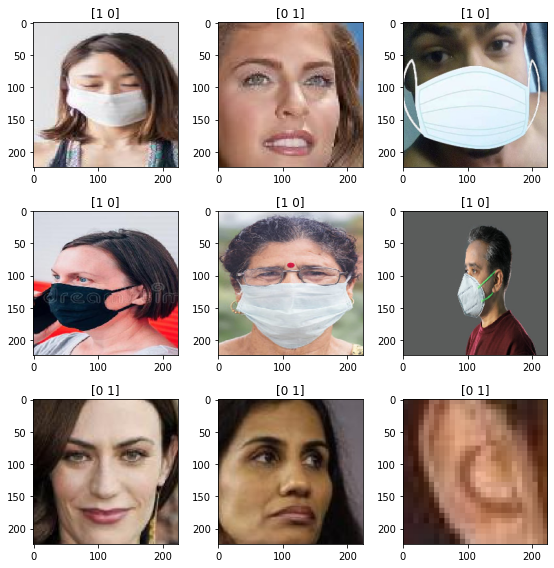

In [86]:
# display training images in original format

orig_tf = ImageDataGenerator()

# using keras image generator, disable save_to_dir if not required
orig_generate = orig_tf.flow_from_directory(train_folder, target_size = (height, width), #save_to_dir = save_folder,
                                              shuffle = True, batch_size = batch_size, class_mode="categorical", seed = seed)
print("TRAINING SET: Sampling original training images ...")
show_grid(orig_generate, max_sample, True)

Found 1600 images belonging to 2 classes.
TRAINING SET: Sampling augmented training images ...
Note: With Mask => [1 0],  Without Mask => [0 1]


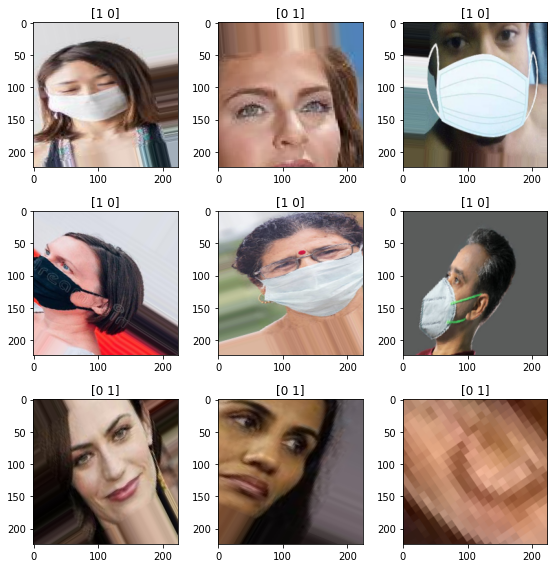

In [87]:
# augment training image set

data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=35,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     zoom_range=0.3)

train_tf = ImageDataGenerator(**data_gen_args)

# using keras image generator, disable save_to_dir if not required
train_generate = train_tf.flow_from_directory(train_folder, target_size = (height, width), #save_to_dir = save_folder,
                                              shuffle = True, batch_size = batch_size, class_mode="categorical", seed = seed)

print("TRAINING SET: Sampling augmented training images ...")
show_grid(train_generate, max_sample, True)

In [88]:
# prepare validation data set for training using Keras `fit` mathod for model training

validate_tf = ImageDataGenerator()

validate_generate = validate_tf.flow_from_directory(validation_folder, target_size = (height, width), shuffle = True, batch_size = v_batch_size, class_mode="categorical")

print("Commpiling model ... ")
model.compile(loss="categorical_crossentropy", optimizer = keras.optimizers.Adam(lr=learning_rate), metrics = ["accuracy"])

print("Fitting model ... ")
history = model.fit(train_generate, epochs = epochs_to_run, steps_per_epoch = batch_size,
                    validation_data = validate_generate, validation_steps = v_batch_size)

Found 400 images belonging to 2 classes.
Commpiling model ... 
Fitting model ... 
Epoch 1/10
16/16 [==============================] - 17s 788ms/step - loss: 8.0429 - accuracy: 0.6647 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
16/16 [==============================] - 11s 678ms/step - loss: 0.1016 - accuracy: 0.9907 - val_loss: 1.4672e-04 - val_accuracy: 1.0000
Epoch 3/10
16/16 [==============================] - 11s 683ms/step - loss: 0.4185 - accuracy: 0.9718 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
16/16 [==============================] - 11s 678ms/step - loss: 0.8820 - accuracy: 0.9644 - val_loss: 0.9620 - val_accuracy: 0.9531
Epoch 5/10
16/16 [==============================] - 11s 679ms/step - loss: 1.9588 - accuracy: 0.9467 - val_loss: 3.2978 - val_accuracy: 0.9375
Epoch 6/10
16/16 [==============================] - 12s 738ms/step - loss: 0.3720 - accuracy: 0.9841 - val_loss: 1.4018 - val_accuracy: 0.9375
Epoch 7/10
16/16 [==============================

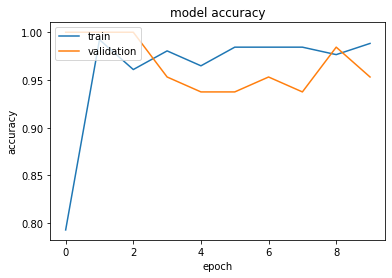

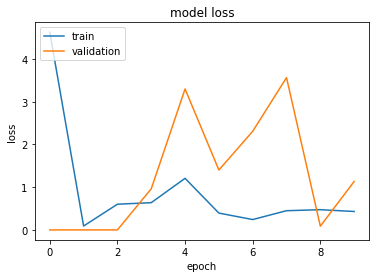

In [89]:
# show accuracy and loss curves

plot_hist(history, "accuracy")
plot_hist(history, "loss")

Found 24 images belonging to 2 classes.
EVALUATION SET: Perform Evaluation on evaluation data set
6/6 [==============================] - 1s 130ms/step - loss: 1.0471 - accuracy: 0.9583
EVALUATION METRICS: Test loss, Accuracy: [1.047073483467102, 0.9583333134651184] 
Sampling evaluation images ...
Note: With Mask => [1 0],  Without Mask => [0 1]


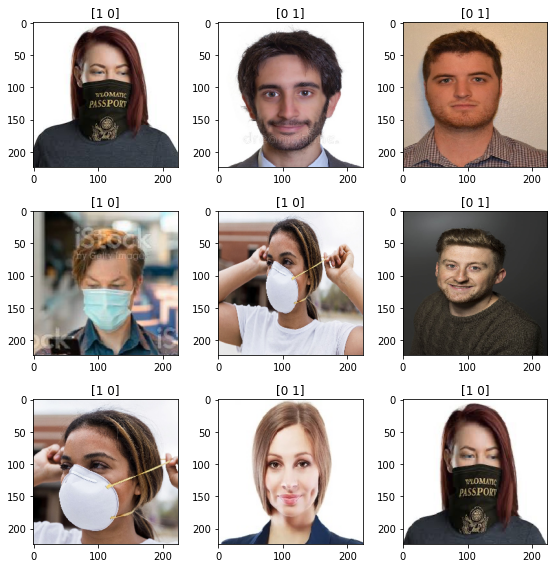

In [90]:
# prepare to evaluate the model on new evaluation data using Keras `evaluate` mathod for model training
eval_tf = ImageDataGenerator()

eval_generate = eval_tf.flow_from_directory(eval_folder, target_size = (height, width), 
                                            shuffle = True, batch_size = t_batch_size, class_mode="categorical")
print("EVALUATION SET: Perform Evaluation on evaluation data set")
results = model.evaluate(eval_generate)
print("EVALUATION METRICS: Test loss, Accuracy:", results, "\r")

print("Sampling evaluation images ...")
show_grid(eval_generate, max_sample, True)

Found 112 images belonging to 3 classes.
TEST SET: Perform testing on test data set
Sampling test images ...


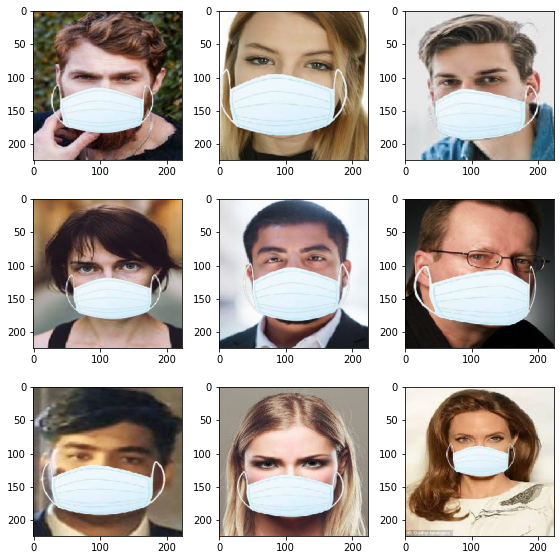

In [91]:
# prepare to test the model on the new test data using  Keras `predict` mathod for model training
test_tf = ImageDataGenerator()

test_generate = test_tf.flow_from_directory(test_folder, target_size = (height, width), 
                                            shuffle = False,batch_size = 1, class_mode="categorical")

print("TEST SET: Perform testing on test data set")

print("Sampling test images ...")
show_grid(test_generate, max_sample, False)

In [92]:
# Generate predictions (probabilities -- the output of the last layer) on new data using `predict`
print("Predictions for test set")

test_generate.reset()
pred = model.predict(test_generate)

# extract labels and filenames for results tabulation into pandas dataframe
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generate.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generate.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

# results.to_csv("results.csv",index=False)

Predictions for test set


In [93]:
# display results
for i in range(0, results.shape[0]):
    print("Prediction is: ", results.Predictions[i], " - for ", results.Filename[i])

Prediction is:  WithMask  - for  WithMask/0-with-mask.jpg
Prediction is:  WithMask  - for  WithMask/1-with-mask.jpg
Prediction is:  WithMask  - for  WithMask/10-with-mask.jpg
Prediction is:  WithMask  - for  WithMask/12-with-mask.jpg
Prediction is:  WithMask  - for  WithMask/13-with-mask.jpg
Prediction is:  WithMask  - for  WithMask/15-with-mask.jpg
Prediction is:  WithMask  - for  WithMask/16-with-mask.jpg
Prediction is:  WithMask  - for  WithMask/2-with-mask.jpg
Prediction is:  WithMask  - for  WithMask/23-with-mask.jpg
Prediction is:  WithMask  - for  WithMask/24-with-mask.jpg
Prediction is:  WithMask  - for  WithMask/25-with-mask.jpg
Prediction is:  WithMask  - for  WithMask/26-with-mask.jpg
Prediction is:  WithMask  - for  WithMask/27-with-mask.jpg
Prediction is:  WithMask  - for  WithMask/29-with-mask.jpg
Prediction is:  WithMask  - for  WithMask/3-with-mask.jpg
Prediction is:  WithMask  - for  WithMask/30-with-mask.jpg
Prediction is:  WithMask  - for  WithMask/31-with-mask.jpg
P